# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

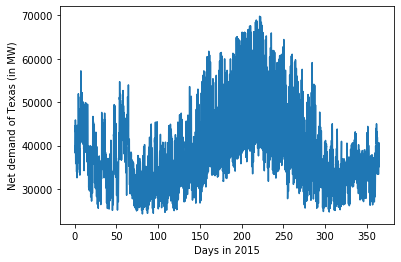

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (5 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**From the above plot I can infer that Texas demands its most power in the moonths of August and September which is when the temperature is very high. Summer is hot! In Illinois, I would expect there to be peak near July/August and a dip near october/november just like texas but another peak near December as it gets extremely cold again. I would also expect the neaw peak at December to be existent till Feb after which there is a dip till July/Aug**


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


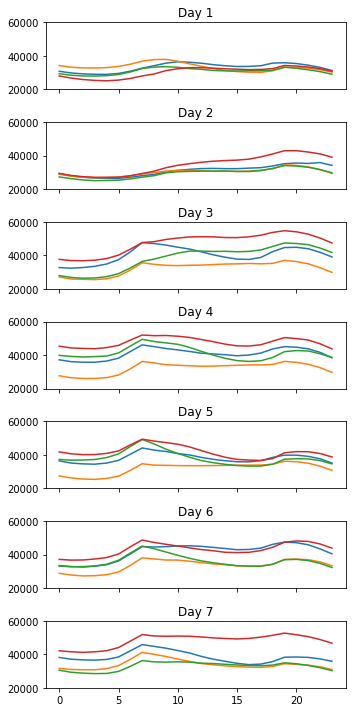

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (5 points).** Can you find any discernible change in the load profiles of different days of the week?

**Yes, Weekends have a delayed initial demand peak as people wake up later than usual and has a very constant demand until people sleep at night. On weekdays there is a peak very early in the day when people wake up for work/school and a dip after which there is another peak towards the evening when everyone has returned home.**  

**Question (15 points).** Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? Do your observations agree with Q1? 

**I see that the daily patterns indicate a consistent use of power when people are awake but the power required is way higher than that for the simalar day's pattern during the month of January. These observations agree with Q1 where August and September Demand a way higher power than January.** 

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


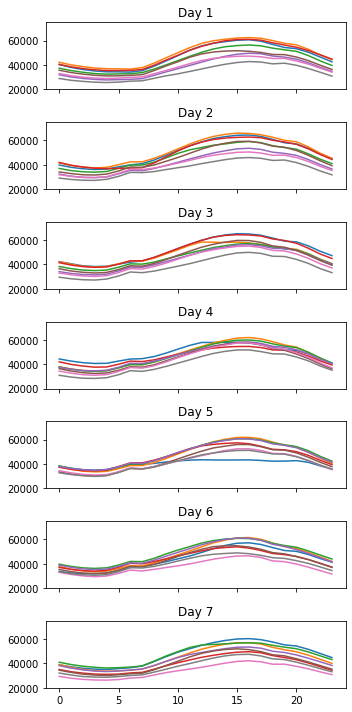

In [5]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 227
numberOfWeeks = 8

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [9]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]

print(X.size()

SyntaxError: unexpected EOF while parsing (<ipython-input-9-c16017a7bc95>, line 8)

When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [15]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

Recall that TensorFlow defines a computation graph where the weights and biases associated with the NN are variables. The goal is to optimize the weights and biases of the NN to minimize prediction error using data. 


To define the computation graph, create the inputs and outputs as 'placeholders'.
The algorithm only expects them to be specified at the time of computation. The
first element of the shape attribute for both inputs and outputs are 'None'. This
means that they are left unspecified, and will be provided at runtime. It will help
in batch training for prediction, where the size of the batch will determine
this value. Batch training is useful because training the NN with one data point at a
time can be time consuming.

In this lab, we begin with a 'relu' activation. We additionally implement 'dropouts' that basically
prevents certain paramters from updating in each round. This is known to prevent overfitting. The number'0.995' in the description below updates 99.5% of all weights, leaving out 0.5%.

Design the optimizer and the loss. For reporting the accuracy of prediction, we choose in this lab the idea of mean absolute error (MAE). For a data set, if the true values are scalars $y_1, \ldots, y_m$ and the predictions are $\hat{y}_1, \ldots, \hat{y}_m$, then its MAE is given by
$$ MAE = \frac{1}{m}\sum|y_i - \hat{y}_i|.$$
If $y$ and $\hat{y}$ are multidimensional, it computes the average across each coordinate of $y$ and $\hat{y}$.

**Question (5 points). Insert a line of code for the output of layer 1 below (use the relu function)** 

In [16]:
# Insert your code where specified
nHidden = 100

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the weights, biases of the first layer.

# insert code
W1 = tf.Variable(tf.random.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.random.truncated_normal(shape=[nHidden]))

# Define the weights, biases of the second layer.

# insert code
W2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.random.truncated_normal(shape=[nDimY]))


# Construct the neural network
@tf.function
def neuralNetworkModel(X):
    global W1, b1, W2, b2
    
    # Define the output of layer 1 (Z1 as a function of the input using relu). 
    
    # insert code
    Z1=tf.nn.relu(tf.matmul(X, W1) + b1)
    outputLayer1 = tf.nn.dropout(Z1, 0.005)
    
    # Define the output of layer 2 (Z2 as a function of outputLayer1 using relu).
    
    # insert code
    Z2=tf.nn.relu(tf.matmul(outputLayer1, W2) + b2)
    outputLayer2 = tf.nn.dropout(Z2, 0.005)
    
    return outputLayer2

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adagrad(learning_rate=1)
# Define the metric (MAE - mean absolute error)
    
# insert code
accuracy = tf.metrics.MeanAbsoluteError()


### Train the neural network.

Create the training module for the NN. Feed the training data in batches of size 'batchSize'
and ask Tensorflow to run the function 'optimizer'. The number of batches, denoted by 'nBatches'
is then given by the size of your training dataset divided by 'batchSize. Usually, going through
the training data once does not train your NN. You train over the same data multiple
times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn
a material by reading through it once!

In [17]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 1000

# Define the training scheme
def train(model, trainX, trainY):
    trainable_variables=[W1, b1, W2, b2]
    for epoch in range(nEpochs):
        lossEpoch = 0
        
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]
            
            # Fit the batch data and compute the gradients
            with tf.GradientTape() as tape:
                prediction = model(batchX)
                loss = loss_fn(y_true=batchY, y_pred=prediction)

                # Print update
                lossEpoch = lossEpoch + loss.numpy()

                # Optimize the weights
                gradients = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(gradients, trainable_variables))
                
        print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
        

print("Started the training module.")

# insert code
import time as time
s=time.time()
train(neuralNetworkModel, trainX, trainY)
t=time.time()
print(t-s)
print("Training process completed.")

Started the training module.
Epoch: 1, Loss: = 5066260928.0
Epoch: 2, Loss: = 1614888608.0
Epoch: 3, Loss: = 1524338928.0
Epoch: 4, Loss: = 1470575824.0
Epoch: 5, Loss: = 1424538416.0
Epoch: 6, Loss: = 1344144112.0
Epoch: 7, Loss: = 1265455728.0
Epoch: 8, Loss: = 1210737696.0
Epoch: 9, Loss: = 1143933792.0
Epoch: 10, Loss: = 1070960576.0
Epoch: 11, Loss: = 990436704.0
Epoch: 12, Loss: = 937259072.0
Epoch: 13, Loss: = 875828992.0
Epoch: 14, Loss: = 820408176.0
Epoch: 15, Loss: = 752584936.0
Epoch: 16, Loss: = 706831320.0
Epoch: 17, Loss: = 687146912.0
Epoch: 18, Loss: = 612296504.0
Epoch: 19, Loss: = 568767808.0
Epoch: 20, Loss: = 545858000.0
Epoch: 21, Loss: = 509832672.0
Epoch: 22, Loss: = 468782576.0
Epoch: 23, Loss: = 462605592.0
Epoch: 24, Loss: = 437645904.0
Epoch: 25, Loss: = 415099688.0
Epoch: 26, Loss: = 407324528.0
Epoch: 27, Loss: = 379884136.0
Epoch: 28, Loss: = 361662840.0
Epoch: 29, Loss: = 350980704.0
Epoch: 30, Loss: = 365817904.0
Epoch: 31, Loss: = 357005892.0
Epoch: 32

Epoch: 262, Loss: = 101465820.0
Epoch: 263, Loss: = 105451520.0
Epoch: 264, Loss: = 104406289.0
Epoch: 265, Loss: = 111433402.0
Epoch: 266, Loss: = 108172547.0
Epoch: 267, Loss: = 95846946.0
Epoch: 268, Loss: = 108827518.0
Epoch: 269, Loss: = 128503002.0
Epoch: 270, Loss: = 95319781.0
Epoch: 271, Loss: = 110706617.0
Epoch: 272, Loss: = 125360900.0
Epoch: 273, Loss: = 103370024.0
Epoch: 274, Loss: = 116325628.0
Epoch: 275, Loss: = 98458310.0
Epoch: 276, Loss: = 112175652.0
Epoch: 277, Loss: = 102227229.0
Epoch: 278, Loss: = 121917824.0
Epoch: 279, Loss: = 105289507.0
Epoch: 280, Loss: = 88583498.0
Epoch: 281, Loss: = 104744049.0
Epoch: 282, Loss: = 106568366.0
Epoch: 283, Loss: = 103090900.0
Epoch: 284, Loss: = 93675420.0
Epoch: 285, Loss: = 106138494.0
Epoch: 286, Loss: = 98192472.0
Epoch: 287, Loss: = 107990673.0
Epoch: 288, Loss: = 103241422.0
Epoch: 289, Loss: = 101235707.0
Epoch: 290, Loss: = 97758742.0
Epoch: 291, Loss: = 109743526.0
Epoch: 292, Loss: = 82394130.0
Epoch: 293, Loss

Epoch: 528, Loss: = 73478484.0
Epoch: 529, Loss: = 91565049.0
Epoch: 530, Loss: = 68615185.0
Epoch: 531, Loss: = 60425471.0
Epoch: 532, Loss: = 73678678.0
Epoch: 533, Loss: = 91544588.0
Epoch: 534, Loss: = 80126504.0
Epoch: 535, Loss: = 76560639.0
Epoch: 536, Loss: = 80476201.0
Epoch: 537, Loss: = 86658755.0
Epoch: 538, Loss: = 70280075.0
Epoch: 539, Loss: = 84017170.0
Epoch: 540, Loss: = 72776100.0
Epoch: 541, Loss: = 81716974.0
Epoch: 542, Loss: = 72653402.0
Epoch: 543, Loss: = 69753627.0
Epoch: 544, Loss: = 81786035.0
Epoch: 545, Loss: = 61598950.0
Epoch: 546, Loss: = 85798769.0
Epoch: 547, Loss: = 80456539.0
Epoch: 548, Loss: = 90916137.0
Epoch: 549, Loss: = 74813449.0
Epoch: 550, Loss: = 73477323.0
Epoch: 551, Loss: = 67308647.0
Epoch: 552, Loss: = 93223519.0
Epoch: 553, Loss: = 63507494.0
Epoch: 554, Loss: = 84470658.0
Epoch: 555, Loss: = 62930817.0
Epoch: 556, Loss: = 72207406.0
Epoch: 557, Loss: = 61700532.0
Epoch: 558, Loss: = 53437651.0
Epoch: 559, Loss: = 74166356.0
Epoch: 5

Epoch: 801, Loss: = 68058929.0
Epoch: 802, Loss: = 73276891.5
Epoch: 803, Loss: = 81753968.0
Epoch: 804, Loss: = 69468408.0
Epoch: 805, Loss: = 66365915.0
Epoch: 806, Loss: = 72129314.0
Epoch: 807, Loss: = 66621412.0
Epoch: 808, Loss: = 60830669.0
Epoch: 809, Loss: = 69112988.0
Epoch: 810, Loss: = 59360689.0
Epoch: 811, Loss: = 75384250.0
Epoch: 812, Loss: = 57005077.0
Epoch: 813, Loss: = 71518756.0
Epoch: 814, Loss: = 63690123.0
Epoch: 815, Loss: = 54977310.0
Epoch: 816, Loss: = 70460625.0
Epoch: 817, Loss: = 54498071.0
Epoch: 818, Loss: = 75745894.0
Epoch: 819, Loss: = 62249479.0
Epoch: 820, Loss: = 60244579.0
Epoch: 821, Loss: = 58549910.0
Epoch: 822, Loss: = 72962758.5
Epoch: 823, Loss: = 75690683.0
Epoch: 824, Loss: = 59395845.0
Epoch: 825, Loss: = 65883793.0
Epoch: 826, Loss: = 50075561.0
Epoch: 827, Loss: = 56874664.0
Epoch: 828, Loss: = 56851451.5
Epoch: 829, Loss: = 77827023.0
Epoch: 830, Loss: = 62194402.0
Epoch: 831, Loss: = 70987282.0
Epoch: 832, Loss: = 85156996.0
Epoch: 8

### Test the accuracy of prediction via NN.

Here, you report the mean absolute error of your predictions over the 'testX' dataset. Finally, plot the actual demand profile versus the predicted demand profile for a few days from the test data.

In [18]:
    predictedY = neuralNetworkModel(testX)
    # insert code
    accuracy.update_state(y_true=testY, y_pred=predictedY)
    maeOfPrediction = accuracy.result().numpy()
    # insert code
    print("Mean absolute error of forecast = ", maeOfPrediction)

Mean absolute error of forecast =  2535.645


**Question (5 points).** Comment whether your MAE is high or low.

**Hint.** Compare the mean absolute error to the maximum demands.

**The Highest Demand is about 60000 MW and the MAE is 2300. This is about 4% of the highest demand. I would say the MAE is pretty low.**

### Let us visualize the results.


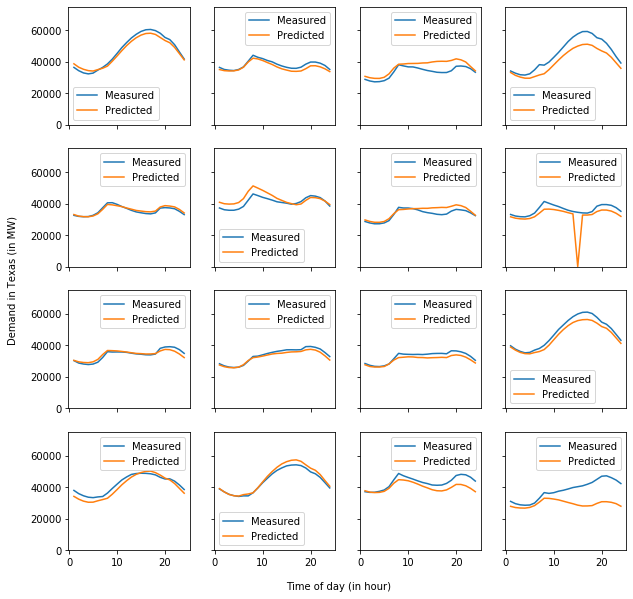

In [19]:
    # Plot the predicted load and compare against the actual load from the test data.
    assert(nTest >= 16)
    days = random.sample(range(nTest), 16)

    fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
    axs = axs.ravel()

    for dd, day in enumerate(days):
        testYDay = testY[day]
        predictedYDay = predictedY[day]

        l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
        l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
        
        axs[dd].set_ylim(bottom=0, top=75000)
        axs[dd].legend()
    
    fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
    fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')
    
    plt.show()

**Question (20 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**10,100,1000 epochs provided more accurate results/ lower MAE Than the previous one. The speed required to train went from 0.2 seconds to 2.2,24 seconds.Beyond 1000, Higher number of epochs simply consume extremely high time to provide only slightly more accurate results. I chose 1000 epochs as it takes lesser time than anything higher than it and predicts with a MAE very close to that produced by higher number of epochs.**

**Question (20 points).** Fix the number of echos to your favorite one, and then explore how the number of neurons affects the accuracy and speed of training. Start with 6 , and increase it to 12, 24, 48, 100, and more. Make comments based on your observations. As an engineer, what is your favorite number of neurons, and why? 

**The number of neurons greatly affects the accuracy. The higher the number of hidden neurons the lower the MAE. It does increase the time taken but only by tiny bit. After about 100 neurons a greater number of neurons does not affect the accuracy to a great extent . I would use about 100 neurons to conserve computational resources.**

**Question (30 points).** Fix the number of epochs and neurons to your favorite ones. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. If the training becomes too slow, you may alter the number of epochs/neurons. 



**Adding another layer while maintaining the same number of epochs and neurons took longer to provide me with a less accurate result. To get an equally accurate result using this extra layer I would have to increase the number of epochs, neurons and computational time by a huge extent.**

In [20]:
# Insert your code where specified
nHidden = 100

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the weights, biases of the first layer.

# insert code
W1 = tf.Variable(tf.random.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.random.truncated_normal(shape=[nHidden]))

# Define the weights, biases of the second layer.
W2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden, nHidden]))
b2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden]))


# insert code
W3 = tf.Variable(tf.random.truncated_normal(shape=[nHidden, nDimY]))
b3 = tf.Variable(tf.random.truncated_normal(shape=[nDimY]))



# Construct the neural network
@tf.function
def neuralNetworkModel2(X):
    global W1, b1, W2, b2, W3, b3
    
    # Define the output of layer 1 (Z1 as a function of the input using relu). 
    
    # insert code
    Z1=tf.nn.relu(tf.matmul(X, W1) + b1)
    outputLayer1 = tf.nn.dropout(Z1, 0.005)
    
    # Define the output of layer 2 (Z2 as a function of outputLayer1 using relu).
    
    # insert code
    Z2=tf.nn.relu(tf.matmul(outputLayer1, W2) + b2)
    outputLayer2 = tf.nn.dropout(Z2, 0.005)
    
    Z3=tf.nn.relu(tf.matmul(outputLayer2, W3) + b3)
    outputLayer3 = tf.nn.dropout(Z3, 0.005)
    
    return outputLayer3

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adagrad(learning_rate=1)
# Define the metric (MAE - mean absolute error)

# insert code
accuracy = tf.metrics.MeanAbsoluteError()


In [21]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 750

# Define the training scheme
def train(model, trainX, trainY):
    trainable_variables=[W1, b1, W2, b2, W3, b3]
    for epoch in range(nEpochs):
        lossEpoch = 0
        
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]
            
            # Fit the batch data and compute the gradients
            with tf.GradientTape() as tape:
                prediction = model(batchX)
                loss = loss_fn(y_true=batchY, y_pred=prediction)

                # Print update
                lossEpoch = lossEpoch + loss.numpy()

                # Optimize the weights
                gradients = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(gradients, trainable_variables))
                
        print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
        

print("Started the training module.")

# insert code
import time as time
s=time.time()
train(neuralNetworkModel2, trainX, trainY)
t=time.time()
print(t-s)
print("Training process completed.")

Started the training module.
Epoch: 1, Loss: = 21411337344.0
Epoch: 2, Loss: = 1644914144.0
Epoch: 3, Loss: = 1199672432.0
Epoch: 4, Loss: = 633133832.0
Epoch: 5, Loss: = 1167627520.0
Epoch: 6, Loss: = 689223384.0
Epoch: 7, Loss: = 434578280.0
Epoch: 8, Loss: = 475547256.0
Epoch: 9, Loss: = 609047456.0
Epoch: 10, Loss: = 345422424.0
Epoch: 11, Loss: = 402247968.0
Epoch: 12, Loss: = 348924076.0
Epoch: 13, Loss: = 469618152.0
Epoch: 14, Loss: = 298095844.0
Epoch: 15, Loss: = 413703544.0
Epoch: 16, Loss: = 270534148.0
Epoch: 17, Loss: = 255146408.0
Epoch: 18, Loss: = 265425608.0
Epoch: 19, Loss: = 257095824.0
Epoch: 20, Loss: = 248137192.0
Epoch: 21, Loss: = 440334844.0
Epoch: 22, Loss: = 265013528.0
Epoch: 23, Loss: = 320938772.0
Epoch: 24, Loss: = 235202148.0
Epoch: 25, Loss: = 309733484.0
Epoch: 26, Loss: = 236332312.0
Epoch: 27, Loss: = 314708936.0
Epoch: 28, Loss: = 197888242.0
Epoch: 29, Loss: = 201740266.0
Epoch: 30, Loss: = 189322424.0
Epoch: 31, Loss: = 250608832.0
Epoch: 32, Los

Epoch: 269, Loss: = 81278197.0
Epoch: 270, Loss: = 74718856.0
Epoch: 271, Loss: = 78848200.0
Epoch: 272, Loss: = 68568947.0
Epoch: 273, Loss: = 80567254.0
Epoch: 274, Loss: = 78956467.0
Epoch: 275, Loss: = 84948462.0
Epoch: 276, Loss: = 90471232.0
Epoch: 277, Loss: = 112603865.0
Epoch: 278, Loss: = 90327712.0
Epoch: 279, Loss: = 60526525.0
Epoch: 280, Loss: = 95641560.0
Epoch: 281, Loss: = 66078532.0
Epoch: 282, Loss: = 73291061.0
Epoch: 283, Loss: = 69139662.0
Epoch: 284, Loss: = 88029162.0
Epoch: 285, Loss: = 76119875.0
Epoch: 286, Loss: = 82786624.0
Epoch: 287, Loss: = 76404328.0
Epoch: 288, Loss: = 71428475.0
Epoch: 289, Loss: = 88171534.0
Epoch: 290, Loss: = 72665950.0
Epoch: 291, Loss: = 79950415.0
Epoch: 292, Loss: = 79062317.0
Epoch: 293, Loss: = 85476996.0
Epoch: 294, Loss: = 66751421.0
Epoch: 295, Loss: = 91687839.0
Epoch: 296, Loss: = 83763075.0
Epoch: 297, Loss: = 91643377.0
Epoch: 298, Loss: = 88668513.0
Epoch: 299, Loss: = 88125883.0
Epoch: 300, Loss: = 65121946.0
Epoch: 

Epoch: 536, Loss: = 49111849.5
Epoch: 537, Loss: = 82446997.0
Epoch: 538, Loss: = 62147854.0
Epoch: 539, Loss: = 76618030.0
Epoch: 540, Loss: = 97521882.0
Epoch: 541, Loss: = 82859126.0
Epoch: 542, Loss: = 63524237.0
Epoch: 543, Loss: = 62288285.0
Epoch: 544, Loss: = 72880408.0
Epoch: 545, Loss: = 65946698.0
Epoch: 546, Loss: = 90846055.0
Epoch: 547, Loss: = 57828202.5
Epoch: 548, Loss: = 56586374.0
Epoch: 549, Loss: = 58394841.5
Epoch: 550, Loss: = 76313691.0
Epoch: 551, Loss: = 92653081.0
Epoch: 552, Loss: = 73008762.0
Epoch: 553, Loss: = 72414934.0
Epoch: 554, Loss: = 65329200.0
Epoch: 555, Loss: = 59511300.0
Epoch: 556, Loss: = 88826024.0
Epoch: 557, Loss: = 55447873.0
Epoch: 558, Loss: = 73037342.0
Epoch: 559, Loss: = 61641540.0
Epoch: 560, Loss: = 68433456.0
Epoch: 561, Loss: = 64076524.0
Epoch: 562, Loss: = 50985429.5
Epoch: 563, Loss: = 66869757.0
Epoch: 564, Loss: = 52425793.5
Epoch: 565, Loss: = 66366369.0
Epoch: 566, Loss: = 65097232.0
Epoch: 567, Loss: = 75711376.0
Epoch: 5

In [22]:
predictedY = neuralNetworkModel2(testX)
    # insert code
accuracy.update_state(y_true=testY, y_pred=predictedY)
maeOfPrediction = accuracy.result().numpy()
    # insert code
print("Mean absolute error of forecast = ", maeOfPrediction)

Mean absolute error of forecast =  2362.3242


### The effect of wind energy (bonus).

In [35]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
5,1/1/15 5:00,1-Jan,38877,745,12730,1.9,5.9,94.0,14.5
6,1/1/15 6:00,1-Jan,39837,788,12730,2.0,6.2,43.0,5.8
7,1/1/15 7:00,1-Jan,40520,758,12730,1.9,6.0,-30.0,-3.8
8,1/1/15 8:00,1-Jan,41008,668,12730,1.6,5.2,-90.0,-11.8
9,1/1/15 9:00,1-Jan,42052,496,12730,1.2,3.9,-172.0,-25.8


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why? Write down your MAE before and after considering wind energy. 

**Your answer (comments here, code below).**
MAE considering wind energy = 2340  and MAE without considering wind = 3900. My accuracy decreased from 3.9% to 6.5% when the wind output was not used. My accuracy was negatively affected because of the absence of training information or an increase in the uncertainity however, MAE didnt change by a lot because wind output has a linearly increasing percentage output over the months and the absence of this linear component in the training data should negatively affect the learning ability but not by a lot. 

In [48]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()-dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'Total Wind Output, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten()- dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'Total Wind Output, MW'].values.flatten() for day in rangeOfDays]



In [49]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


In [50]:
# Insert your code where specified
nHidden = 100

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the weights, biases of the first layer.

# insert code
W1 = tf.Variable(tf.random.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.random.truncated_normal(shape=[nHidden]))

# Define the weights, biases of the second layer.

# insert code
W2 = tf.Variable(tf.random.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.random.truncated_normal(shape=[nDimY]))


# Construct the neural network
@tf.function
def neuralNetworkModel3(X):
    global W1, b1, W2, b2
    
    # Define the output of layer 1 (Z1 as a function of the input using relu). 
    
    # insert code
    Z1=tf.nn.relu(tf.matmul(X, W1) + b1)
    outputLayer1 = tf.nn.dropout(Z1, 0.005)
    
    # Define the output of layer 2 (Z2 as a function of outputLayer1 using relu).
    
    # insert code
    Z2=tf.nn.relu(tf.matmul(outputLayer1, W2) + b2)
    outputLayer2 = tf.nn.dropout(Z2, 0.005)
    
    return outputLayer2

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adagrad(learning_rate=1)
# Define the metric (MAE - mean absolute error)

# insert code
accuracy = tf.metrics.MeanAbsoluteError()

In [46]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 1000

# Define the training scheme
def train(model, trainX, trainY):
    trainable_variables=[W1, b1, W2, b2]
    for epoch in range(nEpochs):
        lossEpoch = 0
        
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]
            
            # Fit the batch data and compute the gradients
            with tf.GradientTape() as tape:
                prediction = model(batchX)
                loss = loss_fn(y_true=batchY, y_pred=prediction)

                # Print update
                lossEpoch = lossEpoch + loss.numpy()

                # Optimize the weights
                gradients = tape.gradient(loss, trainable_variables)
                optimizer.apply_gradients(zip(gradients, trainable_variables))
                
        print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
        

print("Started the training module.")

# insert code
import time as time
s=time.time()
train(neuralNetworkModel3, trainX, trainY)
t=time.time()
print(t-s)
print("Training process completed.")

Started the training module.
Epoch: 1, Loss: = 4067692224.0
Epoch: 2, Loss: = 1831901376.0
Epoch: 3, Loss: = 1696883584.0
Epoch: 4, Loss: = 1599916576.0
Epoch: 5, Loss: = 1493142784.0
Epoch: 6, Loss: = 1404141312.0
Epoch: 7, Loss: = 1331022720.0
Epoch: 8, Loss: = 1273149744.0
Epoch: 9, Loss: = 1200853200.0
Epoch: 10, Loss: = 1164539344.0
Epoch: 11, Loss: = 1117187744.0
Epoch: 12, Loss: = 1074913344.0
Epoch: 13, Loss: = 1030683728.0
Epoch: 14, Loss: = 1002651504.0
Epoch: 15, Loss: = 973345920.0
Epoch: 16, Loss: = 952799872.0
Epoch: 17, Loss: = 934150144.0
Epoch: 18, Loss: = 877372944.0
Epoch: 19, Loss: = 669887120.0
Epoch: 20, Loss: = 574132488.0
Epoch: 21, Loss: = 544904192.0
Epoch: 22, Loss: = 531324856.0
Epoch: 23, Loss: = 525816672.0
Epoch: 24, Loss: = 509944896.0
Epoch: 25, Loss: = 499328368.0
Epoch: 26, Loss: = 509840200.0
Epoch: 27, Loss: = 481844760.0
Epoch: 28, Loss: = 499955512.0
Epoch: 29, Loss: = 476743024.0
Epoch: 30, Loss: = 473022264.0
Epoch: 31, Loss: = 476626240.0
Epoch

Epoch: 268, Loss: = 227006480.0
Epoch: 269, Loss: = 223833068.0
Epoch: 270, Loss: = 222668292.0
Epoch: 271, Loss: = 227533712.0
Epoch: 272, Loss: = 232007160.0
Epoch: 273, Loss: = 222700296.0
Epoch: 274, Loss: = 230160016.0
Epoch: 275, Loss: = 214557080.0
Epoch: 276, Loss: = 220060544.0
Epoch: 277, Loss: = 219372924.0
Epoch: 278, Loss: = 215744956.0
Epoch: 279, Loss: = 225952808.0
Epoch: 280, Loss: = 224323972.0
Epoch: 281, Loss: = 219373596.0
Epoch: 282, Loss: = 222468544.0
Epoch: 283, Loss: = 228067244.0
Epoch: 284, Loss: = 219264732.0
Epoch: 285, Loss: = 222203148.0
Epoch: 286, Loss: = 222522328.0
Epoch: 287, Loss: = 221031944.0
Epoch: 288, Loss: = 226921256.0
Epoch: 289, Loss: = 229241076.0
Epoch: 290, Loss: = 207623460.0
Epoch: 291, Loss: = 216034888.0
Epoch: 292, Loss: = 212570096.0
Epoch: 293, Loss: = 232129952.0
Epoch: 294, Loss: = 223673972.0
Epoch: 295, Loss: = 227766552.0
Epoch: 296, Loss: = 218335908.0
Epoch: 297, Loss: = 232073432.0
Epoch: 298, Loss: = 213561660.0
Epoch: 2

Epoch: 526, Loss: = 207628540.0
Epoch: 527, Loss: = 219867688.0
Epoch: 528, Loss: = 218480948.0
Epoch: 529, Loss: = 214954200.0
Epoch: 530, Loss: = 220034744.0
Epoch: 531, Loss: = 205909268.0
Epoch: 532, Loss: = 217006520.0
Epoch: 533, Loss: = 212764604.0
Epoch: 534, Loss: = 206811460.0
Epoch: 535, Loss: = 200645060.0
Epoch: 536, Loss: = 209854320.0
Epoch: 537, Loss: = 204463692.0
Epoch: 538, Loss: = 213978640.0
Epoch: 539, Loss: = 220421516.0
Epoch: 540, Loss: = 211360744.0
Epoch: 541, Loss: = 213405760.0
Epoch: 542, Loss: = 212269024.0
Epoch: 543, Loss: = 216307692.0
Epoch: 544, Loss: = 222488548.0
Epoch: 545, Loss: = 205332312.0
Epoch: 546, Loss: = 216775168.0
Epoch: 547, Loss: = 207630760.0
Epoch: 548, Loss: = 206130632.0
Epoch: 549, Loss: = 200238580.0
Epoch: 550, Loss: = 217616772.0
Epoch: 551, Loss: = 219137592.0
Epoch: 552, Loss: = 208477552.0
Epoch: 553, Loss: = 205833048.0
Epoch: 554, Loss: = 210755020.0
Epoch: 555, Loss: = 208288872.0
Epoch: 556, Loss: = 218270596.0
Epoch: 5

Epoch: 787, Loss: = 208517972.0
Epoch: 788, Loss: = 199063360.0
Epoch: 789, Loss: = 191387524.0
Epoch: 790, Loss: = 215968764.0
Epoch: 791, Loss: = 204837784.0
Epoch: 792, Loss: = 203438156.0
Epoch: 793, Loss: = 211694084.0
Epoch: 794, Loss: = 210617860.0
Epoch: 795, Loss: = 211998936.0
Epoch: 796, Loss: = 203497340.0
Epoch: 797, Loss: = 213121868.0
Epoch: 798, Loss: = 199403712.0
Epoch: 799, Loss: = 201617428.0
Epoch: 800, Loss: = 207906268.0
Epoch: 801, Loss: = 216728720.0
Epoch: 802, Loss: = 211808988.0
Epoch: 803, Loss: = 205766120.0
Epoch: 804, Loss: = 220881916.0
Epoch: 805, Loss: = 198075176.0
Epoch: 806, Loss: = 204729392.0
Epoch: 807, Loss: = 208449240.0
Epoch: 808, Loss: = 197783660.0
Epoch: 809, Loss: = 193427888.0
Epoch: 810, Loss: = 221144852.0
Epoch: 811, Loss: = 210481640.0
Epoch: 812, Loss: = 200474204.0
Epoch: 813, Loss: = 219474660.0
Epoch: 814, Loss: = 210330196.0
Epoch: 815, Loss: = 192215180.0
Epoch: 816, Loss: = 205853228.0
Epoch: 817, Loss: = 206952988.0
Epoch: 8

In [47]:
predictedY = neuralNetworkModel3(testX)
    # insert code
accuracy.update_state(y_true=testY, y_pred=predictedY)
maeOfPrediction = accuracy.result().numpy()
    # insert code
print("Mean absolute error of forecast = ", maeOfPrediction)

Mean absolute error of forecast =  3904.534
